In [ ]:

import flopy
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import glob
import config
import pandas as pd 

if sys.platform.lower()=='linux':
    datadir = Path('/scratch/users/ianpg/SWIlarge/data')
    workdir = Path('/scratch/users/ianpg/SWIlarge/work')
    MPSdir = datadir.joinpath('lith/sgems/MPS')
    lithdir = datadir.joinpath('lith/sgems/')
    GISdir = datadir.joinpath('GIS')
    priordir = datadir.joinpath('PriorModel')
    modeldir = datadir.joinpath('NM_model')
elif sys.platform.lower()=='darwin':
    datadir = Path('../data')
    workdir = Path('../work')
    MPSdir = Path('/Users/ianpg/Dropbox/temp_convenience/SWIlarge/data/lith/sgems/MPS')
    GISdir = datadir.joinpath('GIS')
    lithdir = datadir.joinpath('lith/sgems/')
    priordir = datadir.joinpath('PriorModel')
    modeldir = datadir.joinpath('NM_model')

nmgwmdir_empty = datadir.joinpath('nmgwmdir_empty') #<-- removed everything but DIS
nmgwmdir_cal = datadir.joinpath('Calibrated_small') #<-- removed RCH, WEL, GLO, LST from the NAM file to load much faster
figdir = workdir.joinpath('figs')
outputdir = workdir.joinpath('output')

In [ ]:
#%% Useful functions
def load_obj(dirname,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'rb') as f:
        return pickle.load(f)

def save_obj(dirname,obj,name):
    import pickle
    with open(Path(dirname).joinpath(name + '.pkl').as_posix(), 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def make_timestamp(YMD=True,HM=True):
    import datetime
    if YMD:
        ymd = '%Y%m%d'
    else:
        ymd = ''
    if HM:
        hm = '%H%M'
    else:
        hm = ''
    if YMD and HM:
        sep = '_'
    else:
        sep = ''
    return datetime.datetime.now().strftime('{}{}{}'.format(ymd,sep,hm))


### Load salinity data and success/failure of runs

##### Load the data

Case: SV
Number of SEAWAT runs: 499 
Failure rate: 4.01 %
loading...
kper 40 it 0
kper 40 it 100
kper 40 it 200
kper 40 it 300
kper 40 it 400
matrices line up!
  
3. Dimension reduction of model and data
2020-07-11 10:08:37:157349
2020-07-11 10:08:55:678867
QC of the model eigen images
2020-07-11 10:08:58:828020
2020-07-11 10:08:59:262320
  
5. Global Sensitivity anlaysis-DGSA


100%|██████████| 3000/3000 [00:55<00:00, 54.47it/s]


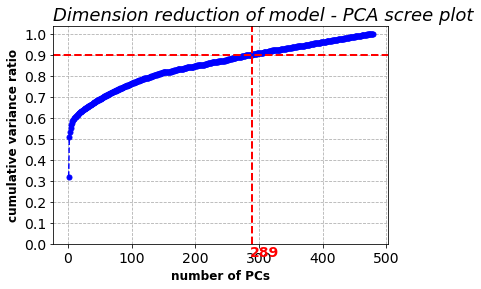

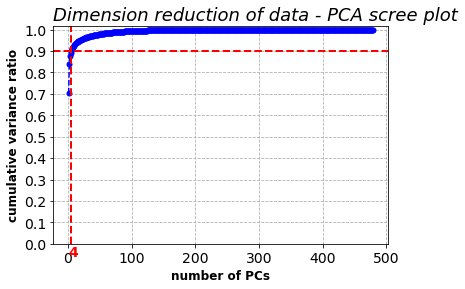

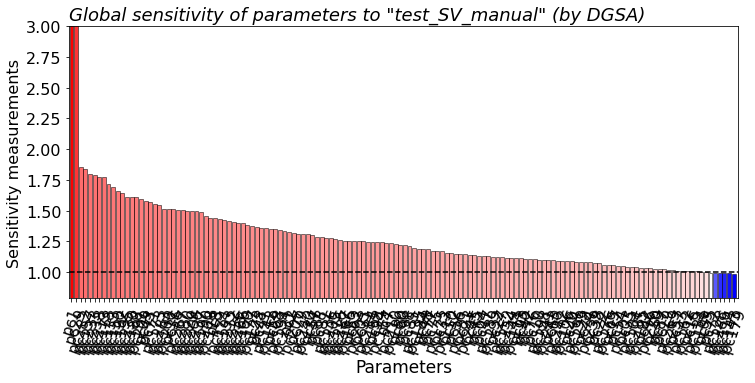

Case: SV
Number of SEAWAT runs: 499 
Failure rate: 4.01 %
loading...
kper 60 it 0
kper 60 it 100
kper 60 it 200
kper 60 it 300
kper 60 it 400
matrices line up!
  
3. Dimension reduction of model and data
2020-07-11 10:15:13:564647
2020-07-11 10:15:31:832156
QC of the model eigen images
2020-07-11 10:15:34:941931
2020-07-11 10:15:35:209085
  
5. Global Sensitivity anlaysis-DGSA


100%|██████████| 3000/3000 [00:56<00:00, 53.18it/s]


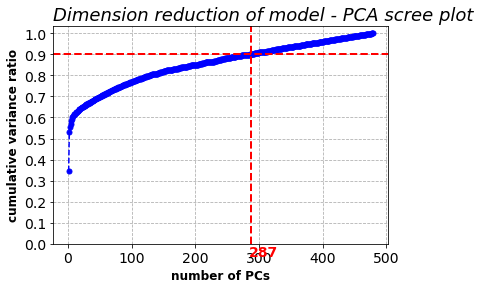

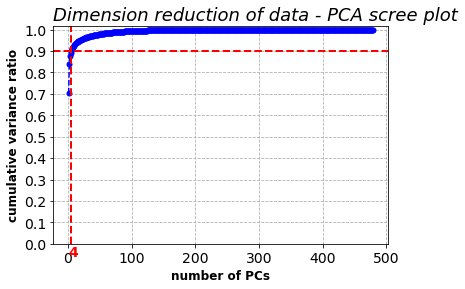

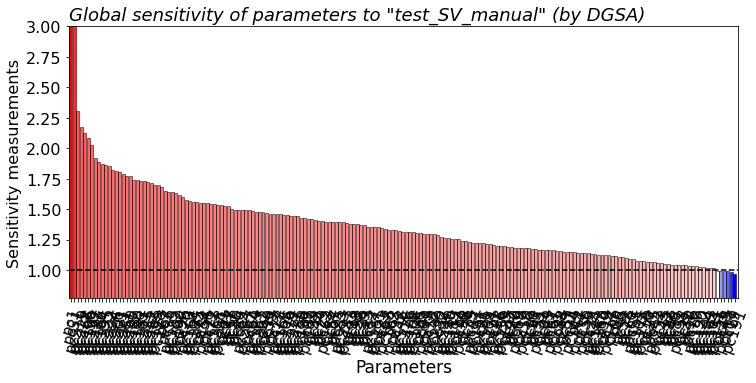

Case: SV
Number of SEAWAT runs: 499 
Failure rate: 4.01 %
loading...
kper 70 it 0
kper 70 it 100
kper 70 it 200
kper 70 it 300
kper 70 it 400
matrices line up!
  
3. Dimension reduction of model and data
2020-07-11 10:21:27:991886
2020-07-11 10:21:46:187192
QC of the model eigen images
2020-07-11 10:21:50:863551
2020-07-11 10:21:51:380553
  
5. Global Sensitivity anlaysis-DGSA


100%|██████████| 3000/3000 [00:54<00:00, 55.42it/s]


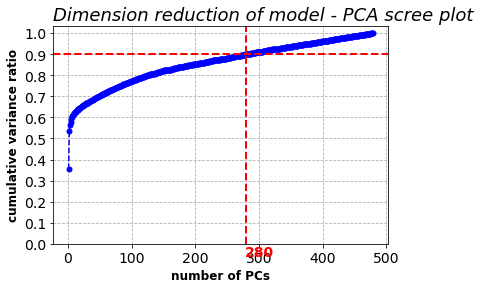

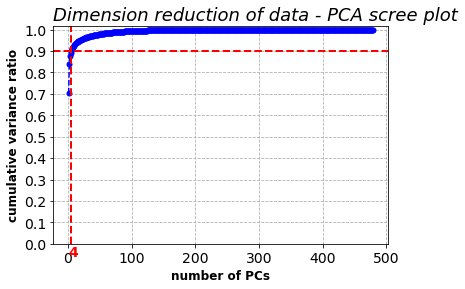

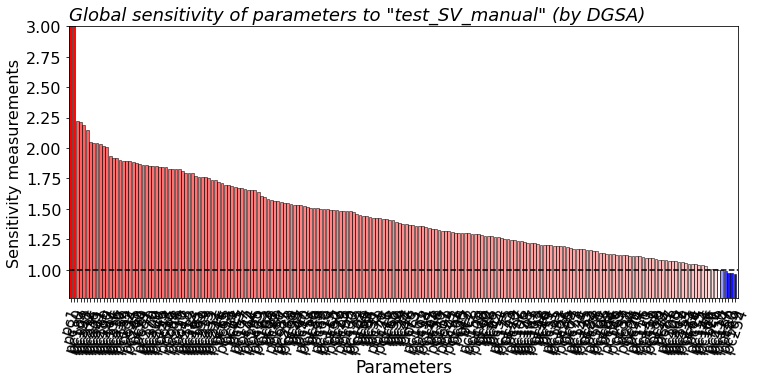

Case: SV
Number of SEAWAT runs: 499 
Failure rate: 4.01 %
loading...
kper 80 it 0
kper 80 it 100
kper 80 it 200
kper 80 it 300
kper 80 it 400
matrices line up!
  
3. Dimension reduction of model and data
2020-07-11 10:27:38:681628
2020-07-11 10:27:56:892510
QC of the model eigen images
2020-07-11 10:27:59:836173
2020-07-11 10:28:00:274082
  
5. Global Sensitivity anlaysis-DGSA


100%|██████████| 3000/3000 [00:52<00:00, 57.29it/s]


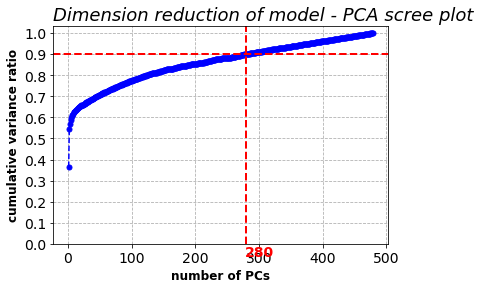

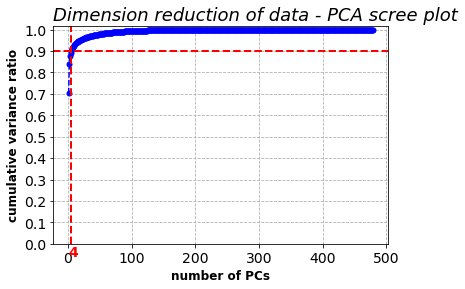

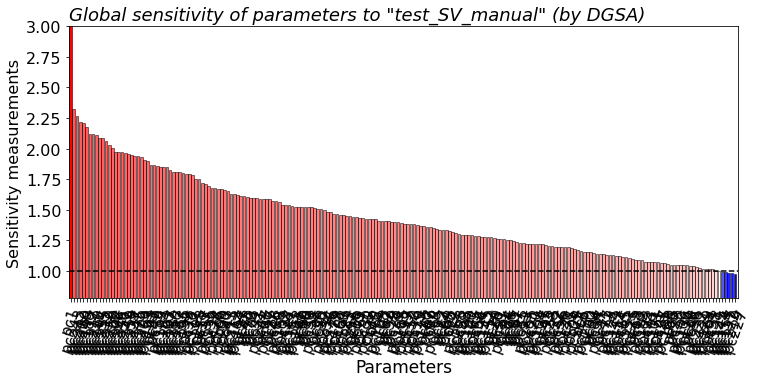

In [5]:
        
#Load a specific concentration for prediction variable
#Already ran kper=0,10,20,30
for kper in (40,60,70,80):


    job_id_AEM = 3573022
    job_id_conc = 3573022
    case='SV'


    # job_id_AEM = 3573239
    # job_id_conc = 3573239 

    # job_id_conc = 3753616 #Jul 7, 2020
    # job_id_conc = 3845000 #Jul 9, 2020
    # case='NM'



    ## Find AEM data files
    ouput_AEM = Path('/scratch/users/ianpg/SWIlarge/work/output/AEM/data/')
    aempaths = glob.glob(ouput_AEM.joinpath('{case}*_{job_id}.npy'.format(case=case,job_id=job_id_AEM)).as_posix())
    its_AEM = np.array([int(f.split('_')[-2]) for f in aempaths])


    output_case = Path('/scratch/users/ianpg/SWIlarge/work/output/{}'.format(case))
    f_varlist = Path('../data/PriorModel/varlist.pkl')
    varlist = load_obj(f_varlist.parent,'varlist')
    ucnpaths = glob.glob(output_case.joinpath('*_{job_id}.UCN'.format(job_id=job_id_conc)).as_posix())
    totims = np.array([int([s for s in f.split('_') if 'totim' in s][0].lstrip('totim')) for f in ucnpaths])
    its_tds = np.array([int(f.split('_')[0].split('/')[-1].lstrip('conc')) for f in ucnpaths])
    failed = totims<14782
    its_failed = its_tds[failed]
    its_success = its_tds[~failed]
    success_AEM = np.array([True if it in its_AEM else False for it in its_tds])

    strange = [(it in its_failed) for it in its_AEM]
    if np.any(strange):
        print('something weird here... failed seawat run ended up with AEM data?')
    #     print('removing these indices...')
    #     success_AEM[np.array(strange)] = False

    print('Case: {}\nNumber of SEAWAT runs: {} \nFailure rate: {} %'.format(case,len(failed),np.round(100*sum(failed)/len(failed),2)))

    print('loading...')
    '''
    d_conc and d_AEM stored by iteration number so there are some empty indices along first axis corresponding to its_failed
    '''
    # d_conc = np.zeros((500,20, 19, 345),dtype=np.float)
    # d_conc_flat = np.zeros((500,20, 19, 345),dtype=np.float)


    # d_AEM = np.zeros((500,2940),dtype=np.float) 
    flag=0
    for f,it_AEM in zip(aempaths,its_AEM):
        if flag==0:
            matshape_AEM = np.load(f).shape
            matsize_AEM= np.prod(matshape_AEM)
            d_AEM = np.zeros((max(its_tds+1),matsize_AEM),dtype=np.float) 
            flag=1
        d_AEM[it_AEM] = np.load(f,allow_pickle=True)


    # flag=0
    # for f,it_tds,it_inAEM in zip(ucnpaths,its_tds,success_AEM):   
    #     if it_inAEM:
    #         if flag==0:
    #             matshape_conc = np.load(f.rstrip('UCN') + 'npy').shape
    #             matsize_conc = np.prod(matshape_conc)
    #             d_conc = np.zeros((max(its_tds+1),matsize_conc))
    #             flag=1
    #         d_conc[it_tds] = np.load(f.rstrip('UCN') + 'npy').flatten()


    
    
    
    
    
    flag=0
    # kper=30   #survey kper: 53
    for i,(f,it_tds,it_inAEM) in enumerate(zip(ucnpaths,its_tds,success_AEM)):  
        if i%100==0:
            print('kper',kper,'it',i)
        if it_inAEM:
            if flag==0:
                matshape_conc = np.load(f.rstrip('UCN') + 'npy').shape
                matsize_conc = np.prod(matshape_conc)
                d_conc = np.zeros((max(its_tds+1),matsize_conc))
                flag=1
    #         d_conc[it_tds] = np.load(f.rstrip('UCN') + 'npy').flatten()
            ucnobj = flopy.utils.binaryfile.UcnFile(f)
            d_conc[it_tds] = ucnobj.get_data(kstpkper=(0,kper)).flatten()







    #Verify that mats have missing rows in same indices
    if np.all((np.where(~d_conc.any(axis=1))[0] ==  np.where(~d_AEM.any(axis=1))[0])):
        print('matrices line up!')
    else:
        print('Warning: matrices do not line up!')        


    keep_inds = np.where(d_conc.any(axis=1))[0]
    d_AEM = -d_AEM[keep_inds,:]
    d_conc = d_conc[keep_inds,:]

    its_AEM = np.sort(its_AEM)
    its_tds = np.sort(its_tds[success_AEM])




    #FROM AUTOBEL

    autobeldir = 'source_code/'
    if autobeldir not in sys.path:
        sys.path.insert(0,autobeldir)


    import numpy as np
    from sklearn.decomposition import PCA

    from source_code.scree_plot import scree_plot
    from source_code.evd_fast import *
    from source_code.RobustMD_flsification import RobustMD_flsification
    from source_code.DGSA_light import DGSA_light
    from source_code.gsa_pareto_plt import gsa_pareto_plt
    from source_code.rgrplt_all_dh import rgrplt_all_dh 
    from source_code.cca_and_ccaplt import cca_d_h
    from source_code.cca_and_ccaplt import cca_plt
    from source_code.gaussianregression_c_dd_star import *
    from source_code.post_est_rtn_val import post_est_rtn_val
    from source_code.post_est_rtn_val import post_est_clsplt
    from source_code.plt_pos_pri_comp import plt_pos_pri_comp


    from source_code.combine_mc_samples import *
    from source_code.signed_distance_functions import *
    from source_code.giip_cal import *

    from source_code.gd_wellog_data import gd_wellog_data
    from source_code.falsifications import fals_1Dplt, fals_2Dplt
    from source_code.outlier_detection import outlier_2d
    from source_code.plt_MC_models_smpls import m_ensampl_plt
    from source_code.plt_MC_models_smpls import mc_samples_plot
    from source_code.qc_reslts_plt import m_ensampl_plt


    print("  ")
    print("3. Dimension reduction of model and data")
    '''m_pcnumsc: the number of model PCs to preserve in dimension reduction'''

    model_name = 'test_SV_manual'

    m_pcnums = []
    m_pri = d_conc.copy()
    m_pri[m_pri>100]=0.


    m_pcnum =scree_plot(m_pri, 'model', 90, 'plot')
    m_pcnums.append(m_pcnum)
    m_mean_pri = m_pri.mean(axis=0)
    m_eigvec_pri = evd_fast(m_pri, len(m_pri))
    m_pcscr_pri=(m_pri-m_mean_pri).dot(m_eigvec_pri)

    output_model = outputdir.joinpath('BEL',case,'model')
    output_data = outputdir.joinpath('BEL',case,'data')

    if not output_model.exists():
        output_model.mkdir(parents=True)
    if not output_data.exists():
        output_data.mkdir(parents=True)




    np.save(output_model.joinpath('{}_mean_pri.npy'.format(model_name)), m_mean_pri)
    np.save(output_model.joinpath('{}_eigvec_pri.npy'.format(model_name)), m_eigvec_pri)
    np.save(output_model.joinpath('{}_pcscr_pri.npy'.format(model_name)), m_pcscr_pri)

    print("QC of the model eigen images")
    # eigen_imgs_local(m_eigvec_pri, np.arange(10), matshape_conc)


    #AEM
    d_pri = np.log(d_AEM.copy())
    d_pri[np.isnan(d_pri)]=0.

    # d_pri = d_AEM.copy()
    # d_obs = d_tds_obs.copy()
    d_obs = d_AEM[408,:].reshape(1,-1)


    d_pcnum =scree_plot(d_pri, 'data', 90, 'plot')
    d_mean_pri = d_pri.mean(axis=0)
    d_eigvec_pri = evd_fast(d_pri, len(d_pri))
    d_pcscr_pri=(d_pri-d_mean_pri).dot(d_eigvec_pri)
    d_pcscr_obs=(d_obs-d_mean_pri).dot(d_eigvec_pri)




    np.save(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)), d_pcscr_pri)
    np.save(output_data.joinpath('{}_dpcscr_obs.npy'.format(model_name)), d_pcscr_obs)
    np.save(output_data.joinpath('{}_dpca_eigenvec.npy'.format(model_name)), d_eigvec_pri)


    ##########################################################################
        ##           STEP 5. GSA               ##
    ##########################################################################
    print("  ")
    print("5. Global Sensitivity anlaysis-DGSA")
    m_pcscr_pri = np.load(output_model.joinpath('{}_pcscr_pri.npy'.format(model_name)))[:, :m_pcnum]
    d_pcscr_pri = np.load(output_data.joinpath('{}_dpcscr_pri.npy'.format(model_name)))[:, :d_pcnum]

    headers = []
    for para in range(m_pcnum):
        headers.append('pc' + str(para + 1))
    try:
        SA_measure = DGSA_light(m_pcscr_pri, d_pcscr_pri, headers)
    except Exception as error:
        print(str(error))
    gsa_pareto_plt(SA_measure, model_name)
    np.save(output_data.joinpath('SA_measure_' + model_name + '.npy'), SA_measure)
    np.save(output_data.joinpath('DGSA_synth_t{}_{}_conc{}_AEM{}.npy'.format(kper,model_name,job_id_conc,job_id_AEM)), SA_measure)
    plt.show()

In [59]:
output_case = Path('/scratch/users/ianpg/SWIlarge/work/output/{}'.format(case))
f_varlist = Path('../data/PriorModel/varlist.pkl')
varlist = load_obj(f_varlist.parent,'varlist')
ucnpaths = glob.glob(output_case.joinpath('*_{job_id}.UCN'.format(job_id=job_id_conc)).as_posix())
model_ws = workdir.joinpath('{}'.format(case))
starttime = np.load(model_ws.joinpath('starttime.npy'))


In [64]:
ucnobj = flopy.utils.binaryfile.UcnFile(ucnpaths[0])
tims = np.array(ucnobj.get_times())
kstpkpers = ucnobj.get_kstpkper()
kpers = np.array([ k[-1] for k in kstpkpers])
kpers_eval = (0,10,20,30,40,60,70,80)
kper_eval_ind =  np.array([max(np.where(kpers==k)[0]) for k in kpers_eval])
tims_eval_real = tims[kper_eval_ind]/365 + starttime

# Plot

In [9]:
output_data = outputdir.joinpath('BEL',case,'data')
kpers_eval = (0,10,20,30,40,60,70,80)
job_id_AEM = 3573022
job_id_conc = 3573022
case='SV'
dgsa_data = []
model_name = 'test_SV_manual'
for kper in kpers:
    dgsa_data.append(np.load(output_data.joinpath('DGSA_synth_t{}_{}_conc{}_AEM{}.npy'.format(kper,model_name,job_id_conc,job_id_AEM))))



In [86]:
import seaborn as sns
[np.quantile(d,1) for d in dgsa_data]

[1.4501376864956148,
 4.362256137584871,
 5.673752672659263,
 6.1462878705593145,
 6.479311147778869,
 6.204611264234833,
 6.862274749526178,
 6.406746294712526]

In [113]:
cmap = sns.cubehelix_palette(n_colors=3, start=.5, rot=-.75)
cmap = sns.color_palette("Paired")


In [117]:
from matplotlib.lines import Line2D

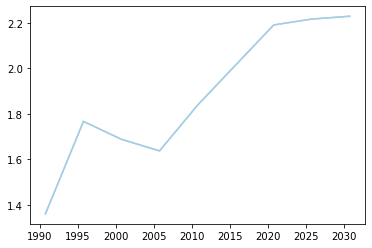

In [135]:
s1 = plt.plot(tims_eval_real,[np.quantile(d,.99) for d in dgsa_data],label='99th quantile',color=cmap[0])
plt.show()

1.2430652018335326

In [169]:
from set_rc import set_rc
set_rc()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


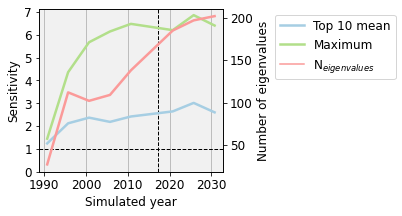

In [185]:
f,ax = plt.subplots(1,figsize=(3.3,3))

# s1=sns.lineplot(tims_eval_real,[d.min() for d in dgsa_data],label='min',ax=ax,palette=cmap)
# sns.lineplot(tims_eval_real,[d.mean() for d in dgsa_data],label='mean',ax=ax)
s1 = plt.plot(tims_eval_real,[np.sort(d.flatten())[-10:].mean() for d in dgsa_data],label='Top 10 mean',color=cmap[0],linewidth=2.5)
s2=plt.plot(tims_eval_real,[d.max() for d in dgsa_data],label='Maximum',color=cmap[2],linewidth=2.5)
s3_empty = Line2D([],[],color = cmap[4],label = 'N$_{eigenvalues}$')


xlims = plt.xlim()
ylims = plt.ylim()

plt.hlines(1,xlims[0],xlims[1],linestyles='--',lw=1)
plt.vlines(2017.3,0,ylims[1],linestyles='--',lw=1)
plt.xlim(xlims)
plt.ylim(0,ylims[1])

plt.xlabel('Simulated year')
plt.ylabel('Sensitivity')
plt.yticks(np.arange(8))
plt.legend(handles=(s1[0],s2[0],s3_empty,),labels=('Top 10 mean','Maximum','N$_{eigenvalues}$'),
           bbox_to_anchor=(1.25, 1.0))

ax2 = plt.twinx(ax=ax)
s3 = plt.plot(tims_eval_real,[len(d[d>1]) for d in dgsa_data],label='n_eig',color=cmap[4],linewidth=2.5)
plt.ylabel('Number of eigenvalues')

# plt.plot(tims_eval_real,[np.median(d) for d in dgsa_data],label='median')
# plt.legend((s1,s2,s3))
# plt.legend((s1,s2,s3))
ax.set_facecolor('#F1F1F1')
ax.grid(True,axis='x')



plt.savefig(figdir.joinpath('DSGA_with_time.eps'),dpi=300,bbox_inches='tight')
plt.show()

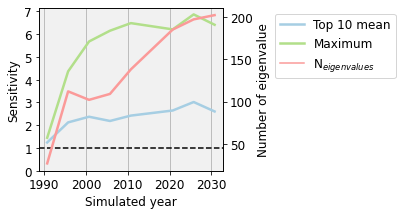

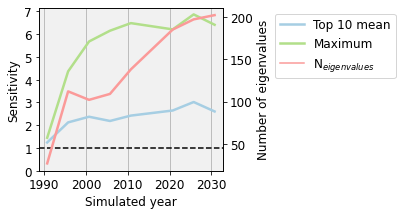

In [179]:
plt.show()

In [109]:
s1.get_children()

 Text(0.5, 1.0, ''),
 Text(0.0, 1.0, ''),
 Text(1.0, 1.0, ''),

In [ ]:
for kper in (
    
    


In [ ]:
#Make main plot
mains = np.diag(vals)
df_plot = pd.DataFrame(data=mains,index=names2latex(df.columns),columns=['Norm. sensitivity'])
df_plot.sort_values(by='Norm. sensitivity',ascending=True,inplace=True)

if main_top_vals is not None:
    df_plot = df_plot.iloc[-main_top_vals:,:]

f,ax= plt.subplots(1,figsize=(3.3,5.5))
colors = sns.cubehelix_palette(n_colors=len(df_plot.index), start=.5, rot=-.75)
x=np.arange(len(df_plot.index))
plt.barh(x,df_plot.loc[:,"Norm. sensitivity"].values,
         color=colors)
plt.xlabel('Normalized sensitivity')
ylims = ax.get_ylim()
xlims = ax.get_xlim()
plt.xticks(ticks=np.arange(10))
plt.vlines(1,ylims[0],ylims[1],lw=1,linestyles='--')
ax.set_ylim(ylims)
ax.set_xlim(0,6)
plt.yticks(ticks=x,labels=df_plot.index.values,rotation=0);
ax.set_facecolor('#F1F1F1')
plt.title('Class {}\n{}, {}'.format(cluster_val_corrected,varname_plot,section_name_plot))
ax.tick_params(axis='both',which='both',pad=1,length=0)
if plotPCA:
    pca_txt='WPCs'
#             plt.savefig(datadir.joinpath('Main{}_{}_{}_{}{}.png'
#                                          .format(pca_txt,varname,section_name,tim_ind,cluster)),dpi=300,bbox_inches='tight')
